In [1]:
import pymysql
import numpy as np
import pandas as pd
import pandas.io.sql as psql
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import ast
import pickle
import re

import scipy.spatial as sp
import scipy.sparse as sparse
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, TruncatedSVD #非負値行列分解(Non Negative Matrix Factorization), 特異値分解

## 映画のレコメンド課題
* 複数ある特徴量からジャンル、キーワードで類似度を計算し似ている映画を抽出する。

In [2]:
%%time
# MySQLへの接続
#githubアップのため、各文字列を伏字にした。
con = pymysql.connect(host="xxx",
                     user="xxx",
                     password="xxx",
                      database="movies",
                     port=3306)

sql = """SELECT m.tmdbId, title, genres, popularity, vote_count, vote_average, keywords
FROM movies_meta as m
JOIN keywords as k ON k.tmdbId=m.tmdbId 
"""

data = psql.read_sql(sql, con)
print(data.shape)

con.close()

(46482, 7)
CPU times: user 2.32 s, sys: 277 ms, total: 2.6 s
Wall time: 5.44 s


In [3]:
data.head()

,tmdbId,title,genres,popularity,vote_count,vote_average,keywords
0,862,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",21.94690,5415.0,7.7,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",17.01550,2413.0,6.9,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",11.71290,92.0,6.5,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",3.85949,34.0,6.1,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",8.38752,173.0,5.7,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [4]:
data.duplicated().value_counts()

False    45445
True      1037
dtype: int64

In [5]:
%%time
data = data.drop_duplicates()

CPU times: user 102 ms, sys: 7.8 ms, total: 110 ms
Wall time: 110 ms


In [6]:
data.duplicated("tmdbId").value_counts()

False    45432
True        13
dtype: int64

In [7]:
%%time
data = data.drop_duplicates(subset="tmdbId")

CPU times: user 27.9 ms, sys: 4.07 ms, total: 31.9 ms
Wall time: 30.5 ms


In [8]:
data.shape

(45432, 7)

## データの確認

### vote_count

count    45429.000000
mean       109.938409
std        491.471473
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64

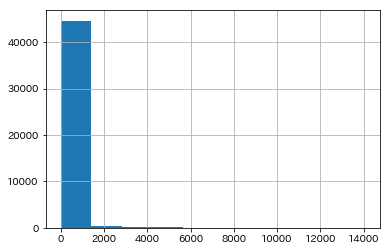

In [9]:
display(data.vote_count.describe())
data.vote_count.hist()

### vote_average

count    45429.000000
mean         5.618453
std          1.923980
min          0.000000
25%          5.000000
50%          6.000000
75%          6.800000
max         10.000000
Name: vote_average, dtype: float64

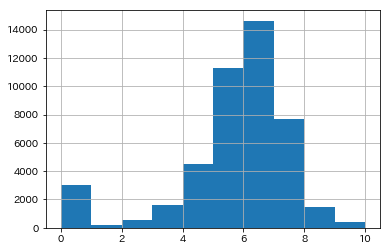

In [10]:
display(data.vote_average.describe())
data.vote_average.hist()

### popularity
* この特徴量は、複数の指標（1日当たりのvote数やビュー数など）を混合したような有用な値らしい。
* 最終的にレコメンドする際の順位づけに使用した。

count    45429.000000
mean         2.921266
std          6.006760
min          0.000000
25%          0.385938
50%          1.127380
75%          3.678190
max        547.488000
Name: popularity, dtype: float64

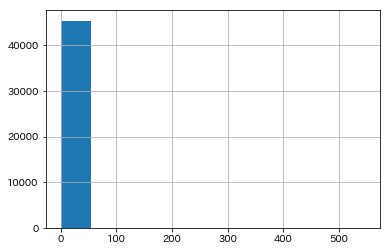

In [11]:
display(data.popularity.describe())
data.popularity.hist()

In [12]:
data[["vote_count", "vote_average", "popularity"]].corr()

,vote_count,vote_average,popularity
vote_count,1.000000,0.123608,0.559994
vote_average,0.123608,1.000000,0.154343
popularity,0.559994,0.154343,1.000000


### genres
* JSON形式で格納されているためパースし、ベクトル化する。

In [13]:
pd.DataFrame(data.genres.value_counts())

,genres
"[{'id': 18, 'name': 'Drama'}]",4996
"[{'id': 35, 'name': 'Comedy'}]",3620
"[{'id': 99, 'name': 'Documentary'}]",2721
[],2441
"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]",1300
"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}]",1133
"[{'id': 27, 'name': 'Horror'}]",974
"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, 'name': 'Romance'}]",930
"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]",593
"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name': 'Comedy'}]",531


In [14]:
def extract_genres(jason_str):
    d = ast.literal_eval(jason_str)
    return [[x["id"], x["name"]] for x in d]

In [15]:
#extract_funcは、json文字列から[id,name]を抜き出すメソッド
def constract_json(data, key, extract_func):
    list_of_json = np.empty((0,3))
    for index, row in data.iterrows():
        a = np.array(extract_func(row[key]))
        if a.shape[0] > 0:
            a = np.insert(a, 0, row["tmdbId"], axis=1)
            list_of_json = np.vstack((list_of_json, a))
        if (index % 5000 == 0) or (index+1 == len(data)):
            print("[{} / {}]".format(index+1, len(data)))
    return pd.DataFrame(list_of_json)

In [16]:
GENRES_RECONSTRUCT = False

In [17]:
%%time
if GENRES_RECONSTRUCT:
    genres_df = constract_json(data, "genres", extract_genres)
    genres_df.columns = ["tmdbId", "id", "name"]
    genres_df = genres_df.drop_duplicates()
    genres_df["tmp"] = 1
    genres_vector_df = genres_df.pivot(index="tmdbId", columns="name", values="tmp")
    del genres_df["tmp"]
    genres_vector_df = genres_vector_df.fillna(0)
    genres_vector_df = genres_vector_df.astype(int)
    genres_vector_df.to_csv("genres_vector_df.csv")

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


In [18]:
if not GENRES_RECONSTRUCT:
    genres_vector_df = pd.read_csv("genres_vector_df.csv" ,index_col=0)

In [19]:
print(genres_vector_df.shape)
genres_vector_df.head()

(42991, 20)


,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
tmdbId,,,,,,,,,,,,,,,,,,,,
100,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10000,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
10001,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
100010,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
100017,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


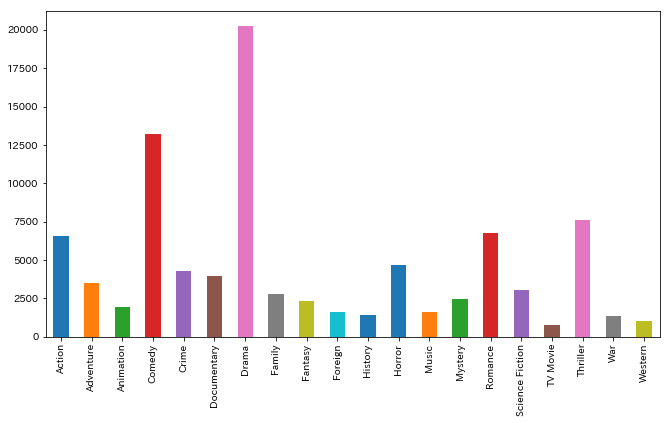

In [20]:
genres_vector_df.sum().plot(kind="bar", figsize=(11,6))

## ジャンルの類似度計算
* 指定映画とその他の映画との類似度を計算し、2000個に絞る

In [21]:
def get_cosine_similarity(x, y):
    return 1- sp.distance.cosine(x, y)

def get_jaccard_similarity(x, y):
    return 1 - sp.distance.jaccard(x, y)

#numpy array形式のmatrixから類似度計算
def get_similar_idx(vector_matrix, target_row, num, similarity_func=get_cosine_similarity):
    user_similarity = []
    for row in vector_matrix:
        sim = similarity_func(target_row, row)
        user_similarity.append(sim)
    user_similarity = np.array(user_similarity)

    return user_similarity.argsort()[::-1][0:num]

In [22]:
%%time
target_row_df = genres_vector_df.query("tmdbId == '597'")

CPU times: user 25.5 ms, sys: 26 ms, total: 51.6 ms
Wall time: 86.6 ms


In [23]:
display(target_row_df)

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
tmdbId,,,,,,,,,,,,,,,,,,,,
597,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0


In [24]:
%%time
target_row = np.matrix(target_row_df)
genres_vector_matrix = np.matrix(genres_vector_df)
similar_idx = get_similar_idx(genres_vector_matrix, target_row, 2000, get_jaccard_similarity)

CPU times: user 1.46 s, sys: 16.5 ms, total: 1.47 s
Wall time: 1.48 s


In [25]:
genres_vector_df.iloc[similar_idx, :]

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
tmdbId,,,,,,,,,,,,,,,,,,,,
18220,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
33788,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
166089,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
114299,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
72272,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
51363,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
46338,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
412105,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
19429,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0


## keywords
* ジャンル同様にキーワードもJSON形式のため、パースしベクトル化する

In [26]:
def extract_keywords(jason_str):
    d = ast.literal_eval(jason_str)
    l = [[x["id"], x["name"]] for x in d]
    return l

In [27]:
%%time
selected_data = data[data["tmdbId"].astype(int).isin(genres_vector_df.index[similar_idx]).values]

CPU times: user 15.9 ms, sys: 5.93 ms, total: 21.9 ms
Wall time: 20 ms


In [28]:
print(selected_data.shape)
selected_data.head()

(2000, 7)


,tmdbId,title,genres,popularity,vote_count,vote_average,keywords
16,4584,Sense and Sensibility,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",10.67320,364.0,7.2,"[{'id': 420, 'name': 'bowling'}, {'id': 818, '..."
21,1710,Copycat,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",10.70180,199.0,6.5,"[{'id': 796, 'name': 'police brutality'}, {'id..."
24,451,Leaving Las Vegas,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",10.33200,365.0,7.1,"[{'id': 30, 'name': 'individual'}, {'id': 549,..."
42,35196,Restoration,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",10.97930,30.0,6.3,"[{'id': 931, 'name': 'jealousy'}, {'id': 1279,..."
48,8391,When Night Is Falling,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",3.30252,10.0,5.9,"[{'id': 1992, 'name': 'professor'}, {'id': 158..."


In [29]:
selected_data.query("tmdbId == '597'")

,tmdbId,title,genres,popularity,vote_count,vote_average,keywords
1643,597,Titanic,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",26.8891,7770.0,7.5,"[{'id': 2580, 'name': 'shipwreck'}, {'id': 298..."


In [30]:
temp = constract_json(selected_data.query("tmdbId == '597'"), "keywords", extract_keywords)
temp.columns = ["tmdbId", "id", "name"]
temp

,tmdbId,id,name
0,597,2580,shipwreck
1,597,2984,iceberg
2,597,3799,ship
3,597,4210,panic
4,597,4388,titanic
5,597,4953,ocean liner
6,597,6917,epic
7,597,7579,rich woman - poor man
8,597,9673,love
9,597,10617,disaster


In [31]:
%%time
keywords_df = constract_json(selected_data, "keywords", extract_keywords)
keywords_df.columns = ["tmdbId", "id", "name"]
keywords_df = keywords_df.drop_duplicates()
keywords_df["tmp"] = 1
keywords_vector_df = keywords_df.pivot(index="tmdbId", columns="name", values="tmp")
del keywords_df["tmp"]
keywords_vector_df = keywords_vector_df.fillna(0)
keywords_vector_df = keywords_vector_df.astype(int)
keywords_vector_df.head()

CPU times: user 2.3 s, sys: 1.5 s, total: 3.8 s
Wall time: 3.81 s


In [32]:
print(keywords_vector_df.shape)
display(keywords_vector_df)

(1493, 3241)


name,16th century,18th century,1910s,1920s,1930s,1940s,1950s,1960s,1970s,1980s,...,young wife,young woman,youngster,youth,youth choir,youth gang,yugoslavia,zehlendorf,nightgown,Øverste hylde
tmdbId,,,,,,,,,,,,,,,,,,,,,
100351,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100490,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101173,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10170,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101752,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10236,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## キーワードの類似度計算

In [33]:
%%time
target_row_df = keywords_vector_df.query("tmdbId == '597'")

CPU times: user 237 ms, sys: 13.6 ms, total: 251 ms
Wall time: 252 ms


In [34]:
target_row_df

name,16th century,18th century,1910s,1920s,1930s,1940s,1950s,1960s,1970s,1980s,...,young wife,young woman,youngster,youth,youth choir,youth gang,yugoslavia,zehlendorf,nightgown,Øverste hylde
tmdbId,,,,,,,,,,,,,,,,,,,,,
597,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
%%time
target_row = np.matrix(target_row_df)
keywords_vector = np.matrix(keywords_vector_df)
similar_idx = get_similar_idx(keywords_vector, target_row, 21, get_jaccard_similarity)

CPU times: user 154 ms, sys: 2.96 ms, total: 157 ms
Wall time: 157 ms


In [36]:
%%time
selected_df = keywords_vector_df.iloc[similar_idx, :]
selected_df

CPU times: user 2.15 ms, sys: 684 µs, total: 2.83 ms
Wall time: 2.53 ms


In [37]:
selected_df = selected_df.drop('597')
selected_df

name,16th century,18th century,1910s,1920s,1930s,1940s,1950s,1960s,1970s,1980s,...,young wife,young woman,youngster,youth,youth choir,youth gang,yugoslavia,zehlendorf,nightgown,Øverste hylde
tmdbId,,,,,,,,,,,,,,,,,,,,,
47697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9062,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152599,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79730,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31056,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
318851,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 結果出力
* ここでは597（titanic）と似ている映画を選出している

In [38]:
for i, tmdbId in enumerate(selected_df.index):
    print("{:>03} :".format(i+1), data.query("tmdbId == '{}'".format(tmdbId))["title"].values[0])

001 : Othello
002 : Love Story
003 : The Immigrant
004 : Sea Wife
005 : A Short Film About Love
006 : Barbara
007 : Sky Of Love
008 : Mera Naam Joker
009 : Confessions of Loving Couples
010 : Syndromes and a Century
011 : À nos amours
012 : Two Gentlemen Sharing
013 : 7/G Rainbow Colony
014 : Seasick
015 : Gertrud
016 : Plain Dirty
017 : Tiger Shark
018 : Miracle in the Rain
019 : Enchantment
020 : The Clairvoyant


## 類似映画を出力する関数を定義し、他の映画についても出力する

In [39]:
def output_similar_title(target_tmdbId):
    #ジャンルで絞る
    target_row_df = genres_vector_df.query("tmdbId == '{}'".format(target_tmdbId))
    target_row = np.matrix(target_row_df)
    genres_vector_matrix = np.matrix(genres_vector_df)
    similar_idx = get_similar_idx(genres_vector_matrix, target_row, 2000, get_jaccard_similarity)
    selected_data = data[data["tmdbId"].astype(int).isin(genres_vector_df.index[similar_idx]).values]

    #キーワードで絞る
    keywords_df = constract_json(selected_data, "keywords", extract_keywords)
    keywords_df.columns = ["tmdbId", "id", "name"]
    keywords_df = keywords_df.drop_duplicates()
    keywords_df["tmp"] = 1
    keywords_vector_df = keywords_df.pivot(index="tmdbId", columns="name", values="tmp")
    del keywords_df["tmp"]
    keywords_vector_df = keywords_vector_df.fillna(0)
    keywords_vector_df = keywords_vector_df.astype(int)

    target_row_df = keywords_vector_df.query("tmdbId == '{}'".format(target_tmdbId))
    target_row = np.matrix(target_row_df)
    keywords_vector = np.matrix(keywords_vector_df)
    similar_idx = get_similar_idx(keywords_vector, target_row, 21, get_jaccard_similarity)
    selected_df = keywords_vector_df.iloc[similar_idx, :]
    selected_df = selected_df.drop('{}'.format(target_tmdbId))
    for i, tmdbId in enumerate(selected_df.index):
        print("{:>03} :".format(i+1), data.query("tmdbId == '{}'".format(tmdbId))["title"].values[0])

* 60308(マネーボール）

In [40]:
%%time
target_tmdbId = 60308
print("***", data.query("tmdbId == '{}'".format(target_tmdbId))["title"].values[0], "***")
output_similar_title(target_tmdbId)

*** Moneyball ***
[30001 / 2000]
001 : The Phenom
002 : The Final Season
003 : Million Dollar Arm
004 : The Babe
005 : 42
006 : Creed
007 : Seven Days in Utopia
008 : Bleed for This
009 : The Reenactment
010 : The Last American Hero
011 : Forever Strong
012 : Jim Thorpe – All-American
013 : The Householder
014 : Sealed Verdict
015 : Rocky Marciano
016 : Fast Girls
017 : This Sporting Life
018 : Running
019 : The Pride of St. Louis
020 : The Reckoning
CPU times: user 3.42 s, sys: 1.05 s, total: 4.47 s
Wall time: 4.46 s


* 767(ハリー・ポッターと謎のプリンス)

In [41]:
%%time
target_tmdbId = 767
print("***", data.query("tmdbId == '{}'".format(target_tmdbId))["title"].values[0], "***")
output_similar_title(target_tmdbId)

*** Harry Potter and the Half-Blood Prince ***
001 : Harry Potter and the Chamber of Secrets
002 : Mister Blot's Academy
003 : Harry Potter and the Order of the Phoenix
004 : Bedknobs and Broomsticks
005 : Harry Potter and the Prisoner of Azkaban
006 : Kiki's Delivery Service
007 : Return to Halloweentown
008 : Harry Potter and the Philosopher's Stone
009 : The Magic Sword
010 : Halloweentown
011 : Pufnstuf
012 : Harry Potter and the Goblet of Fire
013 : Sabrina the Teenage Witch
014 : Halloweentown High
015 : Halloweentown II: Kalabar's Revenge
016 : Warlock
017 : Münchhausen
018 : Witch's Night Out
019 : Conan the Destroyer
020 : Harry Potter and the Deathly Hallows: Part 1
CPU times: user 4.05 s, sys: 1.44 s, total: 5.49 s
Wall time: 5.48 s


## 次元圧縮して類似映画の関係を可視化してみる
* 597（Titanic）を例に。

In [42]:
target_tmdbId = 597
target_row_df = keywords_vector_df.query("tmdbId == '{}'".format(target_tmdbId))
target_row = np.matrix(target_row_df)
keywords_vector = np.matrix(keywords_vector_df)
similar_idx = get_similar_idx(keywords_vector, target_row, 101, get_jaccard_similarity)

In [43]:
%%time
nmf = NMF(n_components=2)
keywords_vector_nmf2 = nmf.fit_transform(keywords_vector_df)

CPU times: user 2.82 s, sys: 105 ms, total: 2.92 s
Wall time: 1.13 s


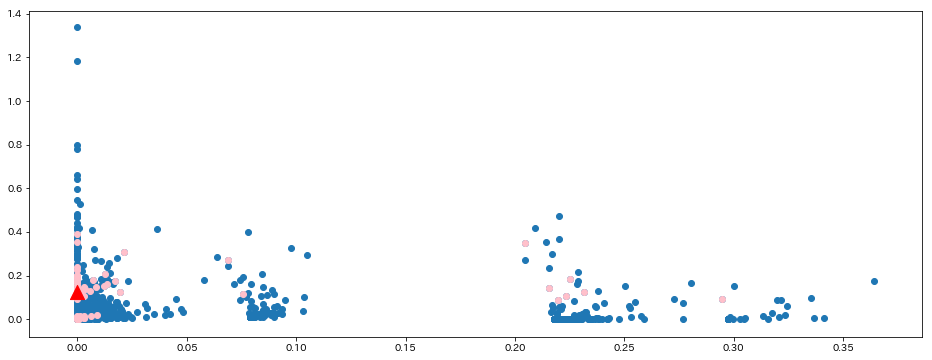

In [44]:
plt.subplots(1,1,figsize=(16,6))
plt.scatter(keywords_vector_nmf2[:, 0], keywords_vector_nmf2[:, 1])
target_idx_on_vector = keywords_vector_df.index.get_loc('597')

#類似映画をプロット
plt.scatter(keywords_vector_nmf2[similar_idx, 0], keywords_vector_nmf2[similar_idx, 1], color="pink")


#ターゲットを赤三角でプロット
plt.scatter(keywords_vector_nmf2[target_idx_on_vector, 0], keywords_vector_nmf2[target_idx_on_vector, 1],
           color = "red", marker="^", s = 200)

## 最終的に、得られた類似映画をpopularity順に表示を並べる
* レコメンド時には、人気順に上位を表示する想定。

In [45]:
selected_df = keywords_vector_df.iloc[similar_idx, :]
selected_df = selected_df.drop('{}'.format(target_tmdbId))
data[data["tmdbId"].isin(selected_df.index)].sort_values("popularity", ascending=False)["title"]

20950                  The Great Gatsby
23557            The Fault in Our Stars
22460            Only Lovers Left Alive
1032                     Romeo + Juliet
1841                              Marty
15272                    Blue Valentine
9476                         Open Water
204                A Walk in the Clouds
17733               Waiting for Forever
15690                According to Greta
15768                        Step Up 3D
7819           The Panic in Needle Park
39177                        The Choice
26600                        I Want You
7874                  Killing Me Softly
2668            Never Talk to Strangers
3026                      Stealing Home
23376                     The Immigrant
14448                   Broken Embraces
4174                         Love Story
23815    Goliyon Ki Raasleela Ram-Leela
16076                        Heartbeats
2520                           Besieged
7025                     Japanese Story
15199                           Voyager
